In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)
import data_prep_pyn as dpp

import pynapple as nap
from sklearn.cluster import KMeans
import database
db = database.db

In [2]:
import ruptures as rpt

import nmf_test as nt

In [14]:
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][2] #0
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118'

In [15]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
behavior=mat_to_return['behavior']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']

load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]


NameError: name 'dpp' is not defined

In [ ]:
fr_pyr = spk_beh_df.loc[:,list(cell_cols_d['pyr'])+list(beh_df.columns)]
# convert to rate (Hz):
dt = np.median(np.diff(beh_df.index))
fr_pyr.loc[:,cell_cols_d['pyr']] = fr_pyr.loc[:,cell_cols_d['pyr']]/dt
speed_thresh=1.
nbins=10
# bin coarsely by lin
fr_filtered = copy.copy(fr_pyr.query("(speed>=@speed_thresh)"))
fr_filtered['lin_binned'] = pd.cut(fr_filtered['lin'],nbins,retbins=False,labels=False)

In [ ]:
import nmf_one_session as nos

trialtype_key_dict = dpp.TRIALTYPE_KEY_DICT
task_index_to_task_name = dpp.get_task_index_to_task_name(spk_beh_df)

# nmf
W_df_d,W_sorted_d,H_sorted_d,W_df_peaks_only_d,W_df_original_d,X_normed_restacked_df_d = {},{},{},{},{},{}

max_fr_thresh = 1.
n_compo = 4

for task_type, fr_filtered_task in fr_filtered.groupby('task_index'):
    trialtype_key=trialtype_key_dict[task_index_to_task_name[task_type]] # visitedArm or direction
    for trial_type, fr_filtered_task_trialtype in fr_filtered_task.groupby(trialtype_key):
        fr_to_be_nmfed_one_trialtype = fr_filtered_task_trialtype.groupby(['trial','lin_binned'])[cell_cols_d['pyr']].mean()
        fr_peak_only = na.get_peaks_in_fr(fr_to_be_nmfed_one_trialtype,max_fr_thresh=max_fr_thresh)

        W_df, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted,X_normed_restacked_df = na.nmf_sort_with_position(fr_to_be_nmfed_one_trialtype,n_compo, model=None,do_normalize=True)

        W_df_original = copy.copy(W_df)
        W_df_peaks_only = W_df.loc[fr_peak_only.index]
        key = (task_type,trial_type)
        W_df_original_d[key] = W_df_original
        W_sorted_d[key] = W_sorted
        W_df_d[key] = W_df
        H_sorted_d[key] = H_sorted
        W_df_peaks_only_d[key] = W_df_peaks_only
        X_normed_restacked_df_d[key] =X_normed_restacked_df
n_clust=6
# post nmf, cluster, add metrics, sort
sort_func = lambda x:na.hierarchical_sort(x,to_cut_keys=[f'skew_{x.name}','skew'],to_cut_nbins=[4,4],final_sort_key=x.name,ascending=False)
W_df_peaks_only_post_sorted_d = {}
for key,W in W_df_peaks_only_d.items():
    W_df_original = W_df_original_d[key]
    X_normed_restacked_df=X_normed_restacked_df_d[key] 

    # kmeans clustering
    res=KMeans(n_clust).fit(W)
    clust = res.labels_
    centroid = res.cluster_centers_
    dist = res.transform(W)
    dist_to_own_centroid = np.diag(dist[:,clust])

    # add metrics
    W_df = na.add_metrics_to_W(W, n_compo, pd_kwargs={})
    W_df['clust'] = clust
    W_df['factor'] = W_df.loc[:,0:n_compo-1].idxmax(axis=1)
    W_df['neg_dist_to_centroid'] = -dist_to_own_centroid # for easiness of sorting; all features the higher the better

    # sort
    W_df_sorted = W_df.groupby('factor').apply(sort_func)
    W_df_peaks_only_post_sorted_d[key] = W_df_sorted

In [20]:

from sklearn.decomposition import NMF, non_negative_factorization

In [25]:
X_normed_restacked_df.values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06071429, 0.04897959, 0.17662338, ..., 0.03688969, 0.19428571,
        0.08831169],
       [0.16558442, 0.06200608, 0.05789972, ..., 0.02602041, 0.        ,
        0.        ],
       [0.        , 0.07108014, 0.3790256 , ..., 0.03349754, 0.        ,
        0.03179221]])

In [18]:
key = (0,0)
X_normed_restacked_df = X_normed_restacked_df_d[key]

n_shuffle=500
# w_l=[]
# for i in range(n_shuffle):
#     X_shuffled= np.random.permutation(X_normed_restacked_df.values.T).T
#     w,h,niter=non_negative_factorization(X_shuffled,n_components=n_compo,H=H_sorted_d[key].values,update_H=False)
#     w_l.append(w)

# w_l = np.array(w_l)
# p_val = (w_original.values < w_l).sum(axis=0) / w_l.shape[0]
# p_val_df = pd.DataFrame(p_val,index=w_original.index)

# X_normed_restacked_df.values
reload(nt)
w_original=W_df_original_d[key]
H_original=H_sorted_d[key].values
p_val_df,w_l=nt.test_w(X_normed_restacked_df,w_original,H_original,n_shuffle=500)

In [83]:
inds=pd.MultiIndex.from_arrays([W_df_peaks_only_post_sorted_d[key].index.get_level_values(1),W_df_peaks_only_post_sorted_d[key].index.get_level_values(2)])
p_val_peaks_only_post_sorted_df=p_val_df.loc[inds] 


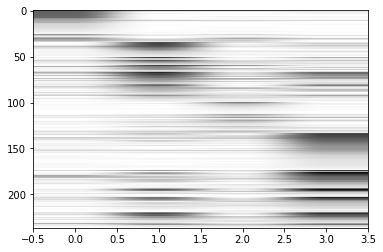

In [89]:
plt.imshow(W_df_peaks_only_post_sorted_d[key].loc[:,0:(n_compo-1)],aspect='auto',interpolation=None)

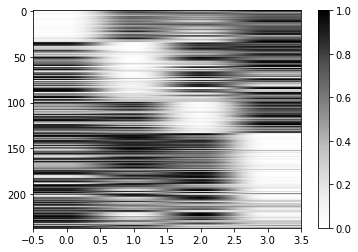

In [96]:
plt.imshow(p_val_peaks_only_post_sorted_df,aspect='auto',interpolation=None)
plt.colorbar()

In [103]:
X_normed_restacked_df

trial               0.0       1.0       4.0       6.0       7.0       8.0   \
    lin_binned                                                               
1   0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    3           0.000000  0.621345  0.000000  0.000000  0.000000  0.000000   
    4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
135 5           0.161905  0.216490  0.104496  0.095377  0.085136  0.120970   
    6           0.292314  0.310457  0.174359  0.275366  0.218571  0.251923   
    7           0.060714  0.048980  0.176623  0.124012  0.000000  0.000000   
    8           0.165584  0.062006  0.057900  0.000000  0.021429  0.000000   
    9           0.000000  0.071080  0.379026  0.470630  0.072857  0.000000   

trial               10.0      11.0      12.0      14.0      15.0      16.0  \
    lin_binned                                                               
1   0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
135 5           0.214668  0.273214  0.186994  0.178897  0.260495  0.291041   
    6           0.365863  0.208163  0.207490  0.308446  0.201647  0.346454   
    7           0.000000  0.085714  0.032381  0.064404  0.061353  0.217484   
    8           0.045536  0.022947  0.017503  0.016190  0.000000  0.000000   
    9           0.176623  0.175176  0.098124  0.134130  0.000000  0.000000   

trial               18.0      20.0      21.0  
    lin_binned                                
1   0           0.000000  0.000000  1.000000  
    1           0.000000  0.000000  0.000000  
    2           0.000000  0.000000  0.000000  
    3           0.000000  0.000000  0.000000  
    4           0.000000  0.000000  0.000000  
...                  ...       ...       ...  
135 5           0.219792  0.228308  0.134347  
    6           0.346564  0.272627  0.094620  
    7           0.036890  0.194286  0.088312  
    8           0.026020  0.000000  0.000000  
    9           0.033498  0.000000  0.031792  

[1140 rows x 15 columns]

In [111]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [19]:
X_normed_restacked_df.shape

(1140, 15)

CPU times: user 28.7 s, sys: 16.9 s, total: 45.7 s
Wall time: 11.9 s


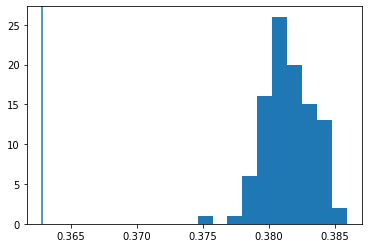

In [24]:
reload(nt)
%time err_shuffle_l, pval=nt.test_co_variation(X_normed_restacked_df.iloc[:,5:],n_compo,n_shuffle=100)

In [9]:
X_normed_restacked_df

trial               2.0       3.0       5.0       9.0       13.0      17.0  \
    lin_binned                                                               
1   0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2           0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
    3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
135 5           0.536376  0.407944  0.673501  0.166158  0.193012  0.182899   
    6           0.000000  0.127376  0.056980  0.151464  0.119200  0.043013   
    7           0.105242  0.398467  0.000000  0.000000  0.022291  0.000000   
    8           0.041687  0.096538  0.000000  0.000000  0.444933  0.050950   
    9           0.702160  0.048269  0.556511  0.070161  0.000000  0.689726   

trial               19.0  
    lin_binned            
1   0           0.000000  
    1           0.000000  
    2           0.000000  
    3           0.000000  
    4           0.000000  
...                  ...  
135 5           0.061728  
    6           0.090419  
    7           0.000000  
    8           0.000000  
    9           0.072132  

[1140 rows x 7 columns]

In [129]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [154]:
%%time
train_ratio = .9
n_cv = 10
n_compo_l = [1,2,3,4]
err_l_d={}
train_err_d={}
for n_compo in n_compo_l:
#     n_compo = 4
    err_l = []
    train_err_ll=[]
    for i in range(n_cv):
        train_mask = np.random.rand(*X_normed_restacked_df.shape) < train_ratio
        test_err, W, H, Z, recon, i, converged, train_err_l = na.masked_nmf(X_normed_restacked_df.values, n_compo, train_mask,max_iters=50,tol=1e-8)
        err_l.append(test_err)
        train_err_ll.append(train_err_l[-1])
    err_l = np.array(err_l)
    err_l_d[n_compo] = err_l
    train_err_d[n_compo]=train_err_ll

CPU times: user 25.7 s, sys: 36.3 s, total: 1min 1s
Wall time: 15.5 s


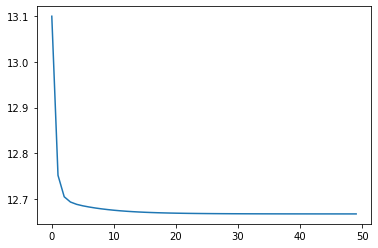

In [149]:
plt.plot(train_err_l)

<AxesSubplot:>

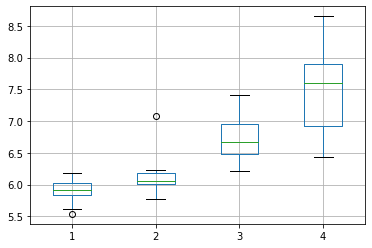

In [152]:
pd.DataFrame(err_l_d).boxplot()

<AxesSubplot:>

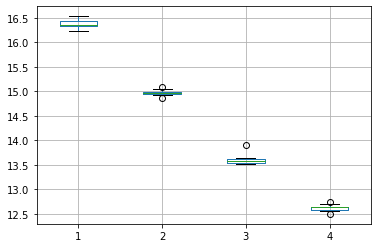

In [155]:
pd.DataFrame(train_err_d).boxplot()